In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
%cd /content/drive/MyDrive/ANN2DL_HW2_Shared

/content/drive/MyDrive/ANN2DL_HW2_Shared


In [76]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
import shutil
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [77]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [78]:
normalization = 'standard'
axis = 2
class_weighting = False
oversampling = False

# Load and preprocess data

In [79]:
x_file_path = "./original_data/x_train.npy"
y_file_path = "./original_data/y_train.npy"

X = np.load(x_file_path)
y = np.load(y_file_path)

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=seed)
n_dimensions = X_train.shape[2]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2186, 36, 6), (2186,), (243, 36, 6), (243,))

In [81]:
label_mapping = {
    "Wish",
    "Another",
    "Comfortably",
    "Money",
    "Breathe",
    "Time",
    "Brain",
    "Echoes",
    "Wearing",
    "Sorrow",
    "Hey",
    "Shine"
}

## Normalization

In [82]:
def normalize(X_train, axis, norm_type='no_norm'):
  axs = [0,1,2]
  axs.remove(axis)
  axs=tuple(axs)

  means = np.mean(X_train, axis=axs)
  stds = np.std(X_train, axis=axs)
  mins = np.min(X_train, axis=axs)
  maxs = np.max(X_train, axis=axs)

  params = {
      "means": means,
      "stds": stds,
      "mins": mins,
      "maxs": maxs
  }
  
  if norm_type=='standard':
    X_std_train = []
    
    for i in range(X_train.shape[axis]):
      data = np.take(X_train, i, axis=axis)
      data = (data - means[i]) / stds[i]
      X_std_train.append(data)

    X_std_train = tuple(X_std_train)
    X_std_train = np.stack(X_std_train, axis=axis)

    return X_std_train, params


  elif norm_type=='minmax':
    X_norm_train = []
    
    for i in range(X_train.shape[axis]):
      data = np.take(X_train, i, axis=axis)
      data = (data - mins[i]) / (maxs[i] - mins[i])
      X_norm_train.append(data)

    X_norm_train = tuple(X_norm_train)
    X_norm_train = np.stack(X_norm_train, axis=axis)

    return X_norm_train, params

  else:
    return X_train, params




In [83]:
def normalize_test(X, params, axis, norm_type='no_norm'):
  
  if norm_type=='standard':
    X_std_val = []

    means = params["means"]
    stds = params["stds"]
    mins = params["mins"]
    maxs = params["maxs"]

    for i in range(X.shape[axis]):
      data = np.take(X, i, axis=axis)
      data = (data - means[i]) / stds[i]
      X_std_val.append(data)

    X_std_val = tuple(X_std_val)
    X_std_val = np.stack(X_std_val, axis=axis)

    return X_std_val

  elif norm_type=='minmax':
    X_norm_val = []
    
    for i in range(X.shape[axis]):
      data = np.take(X, i, axis=axis)
      data = (data - mins[i]) / (maxs[i] - min)
      X_norm_val.append(data)

    X_norm_val = tuple(X_norm_val)
    X_norm_val = np.stack(X_norm_val, axis=axis)

    return X_norm_val

  else:
    return X

In [84]:
X_train, p = normalize(X_train, axis, norm_type=normalization)
X_val = normalize_test(X_val, p, axis, norm_type=normalization)

## Comput class weights

In [85]:
if class_weighting:
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

  fig = plt.figure(figsize=(21, 5))
  plt.bar(np.arange(12), class_weights, width=1, edgecolor="white", tick_label=list(label_mapping))
  plt.show()

In [86]:
if class_weighting:
  class_weights = dict(zip(np.arange(12), class_weights))
  class_weights

## Random oversampling and undersampling

In [87]:
if oversampling:
  ros = RandomOverSampler(random_state=seed)
  smote = SMOTE(random_state=seed)
  adasyn = ADASYN(random_state=seed)
  smoteenn = SMOTEENN(random_state=seed)
  smote_tomek = SMOTETomek(random_state=seed)

  X1 = []

  for dim in range(n_dimensions):
    X_dim = X_train[:,:,dim]
    X1.append(X_dim)

  X1 = np.concatenate(X1, axis=1)
  X_ros, y_ros = adasyn.fit_resample(X1, y_train)
  X_ros = np.reshape(X_ros, (X_ros.shape[0], 36, 6), order='F')
  X_train, y_train = X_ros, y_ros

In [88]:
if oversampling:
  plt.bar(np.arange(12), np.argmax(y_ros), width=1, edgecolor="white", tick_label=list(np.arange(12)))
  plt.show()

# to categorical data

In [89]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_train.shape, y_val.shape

((2186, 12), (243, 12))

In [90]:
X_train.shape, y_train.shape

((2186, 36, 6), (2186, 12))

# Utility function and classes definitions

In [91]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name, experiments_name):

  exps_dir = os.path.join(experiments_name)
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  return callbacks

# Model building function

In [92]:
def build_classifier(input_shape, classes, model_name, lr=0.001):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn2 = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn1)
    cnn = tfkl.Add()([cnn1, cnn2])
    cnn = tfkl.MaxPooling1D()(cnn)
    
    cnn1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn2 = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn1)
    cnn = tfkl.Add()([cnn1, cnn2])
    cnn = tfkl.MaxPooling1D()(cnn)

    drop = tfkl.Dropout(0.4)(cnn)

    cnn1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(drop)
    cnn2 = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn1)
    cnn = tfkl.Add()([cnn1, cnn2])
    cnn = tfkl.MaxPooling1D()(cnn)

    cnn1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn2 = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn1)
    cnn = tfkl.Add()([cnn1, cnn2])
    cnn = tfkl.MaxPooling1D()(cnn)

    drop = tfkl.Dropout(0.4)(cnn)

    gap = tfkl.GlobalAveragePooling1D()(drop)
    #gap = tfkl.Dropout(0.4, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.L1L2(l1=1e-4, l2=1e-3))(gap)
    #classifier = tfkl.Dropout(0.4, seed=seed)(classifier)

    drop = tfkl.Dropout(0.4)(classifier)
    
    output_layer = tfkl.Dense(12, activation='softmax')(drop)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name=model_name)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics='accuracy')

    # Return the model
    return model

# Parameters for training

In [93]:
model_name = "Conv1D_bagging_without_oversampling"
experiments_name = "Oversampling_weighted_loss_normalization"

n_splits = 20

input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

patience1 = 20
patience_plateau = 5
min_lr = 1e-5
lr_factor = 0.5

# Build the model

In [94]:
model = build_classifier(input_shape, classes, model_name)
model.summary()

Model: "Conv1D_bagging_without_oversampling"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_352 (Conv1D)            (None, 36, 256)      4864        ['Input[0][0]']                  
                                                                                                  
 conv1d_353 (Conv1D)            (None, 36, 256)      196864      ['conv1d_352[0][0]']             
                                                                                                  
 add_176 (Add)                  (None, 36, 256)      0           ['conv1d_352[0][0]',             
                                                                

# Bagging class definition

In [95]:
class BaggingModel(tfk.Model):
  def __init__(self, n_splits, inp, classes, model_name):
    super().__init__()
    self.n_splits = n_splits
    self.inp = inp
    self.classes = classes
    self.model_name = model_name
    self.models = []
    for i in range(self.n_splits):
      name = model_name + str(i)
      self.models.append(build_classifier(self.inp, self.classes, name))

  def fit(self,
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False):

    cbs = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience1, restore_best_weights=False),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=patience_plateau, factor=lr_factor, min_lr=min_lr)]

    for i, model in enumerate(self.models):  
      # multiple train-test splits
      scores = []
      n_samples = x.shape[0]

      # select indexes
      ix = [i for i in range(n_samples)]
      train_ix = resample(ix, replace=True, n_samples=n_samples)
      test_ix = [x for x in ix if x not in train_ix]

      # select data
      X_train, y_train = tf.gather(x, indices=train_ix), y[train_ix]
      X_test, y_test = tf.gather(x, indices=test_ix), y[test_ix]

      # train model
      print("Training of model ", str(i))
      history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(X_test, y_test),
        callbacks = cbs,
        shuffle = True
      ).history
      print()

      score = model.evaluate(X_test, y_test)
      scores.append(score)
    
    print("Validation scores for each model:")

    for i, score in enumerate(scores):
      print("Score of model ", str(i))
      print(score)
      print()
        


  def predict(self, x):
    # make predictions
    yhats = [model.predict(x) for model in self.models]
    
    yhats = np.array(yhats)
   
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)

    # argmax across classes
    result = np.argmax(summed, axis=1)

    result = tfk.utils.to_categorical(result)
    
    # return the result
    return result
    pass

  def save(self,
      filepath,
      overwrite=True,
      include_optimizer=True,
      save_format=None,
      signatures=None,
      options=None,
      save_traces=True
  ):

    parent_dir = filepath
    if os.path.exists(parent_dir):
            shutil.rmtree(parent_dir)
    os.mkdir(parent_dir)

    for i, model in enumerate(self.models):
      directory = self.model_name + str(i)
      path = os.path.join(parent_dir, directory)
      if os.path.exists(path):
          shutil.rmtree(path)
      os.mkdir(path)
      model.save(path)

  def load(self, filepath):
    parent_dir = filepath
    for i in range(self.n_splits):
      directory = self.model_name + str(i)
      path = os.path.join(parent_dir, directory)
      if os.path.exists(path):
        self.models[i] = tfk.models.load_model(path)

    

# Training

In [96]:
%cd ./andrea/Conv1D

/content/drive/MyDrive/ANN2DL_HW2_Shared/andrea/Conv1D


In [97]:
model = BaggingModel(n_splits, input_shape, classes, model_name)

In [98]:
model.fit(x = X_train,
      y = y_train,
      batch_size = batch_size,
      epochs = epochs)

Training of model  0
Epoch 1/200
18/18 [==============================] - 2s 39ms/step - loss: 2.9229 - accuracy: 0.2731 - val_loss: 2.6441 - val_accuracy: 0.3176 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - 0s 16ms/step - loss: 2.4868 - accuracy: 0.3550 - val_loss: 2.4700 - val_accuracy: 0.3527 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - 0s 15ms/step - loss: 2.3884 - accuracy: 0.3824 - val_loss: 2.3826 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/200
18/18 [==============================] - 0s 14ms/step - loss: 2.2588 - accuracy: 0.3994 - val_loss: 2.2421 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 5/200
18/18 [==============================] - 0s 14ms/step - loss: 2.1456 - accuracy: 0.3989 - val_loss: 2.1535 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/200
18/18 [==============================] - 0s 15ms/step - loss: 2.0436 - accuracy: 0.4350 - val_loss: 2.2618 - val_accuracy: 0.3830 - lr: 0.0010
Epoch 7/200
18/18 [==============================

In [99]:
# Predict the test set with the RNN
predictions = model.predict(X_val)
predictions.shape

8/8 [==============================] - 0s 4ms/step


(243, 12)

Accuracy: 0.7819
Precision: 0.7074
Recall: 0.6816
F1: 0.6277


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


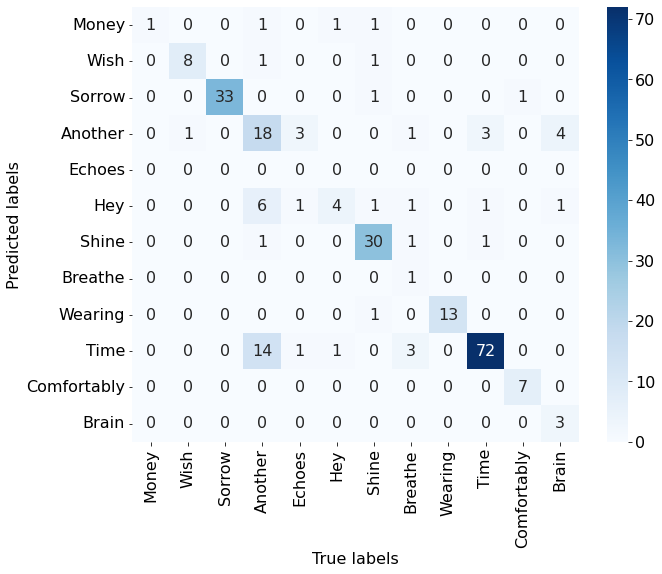

In [100]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping), yticklabels=list(label_mapping), annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

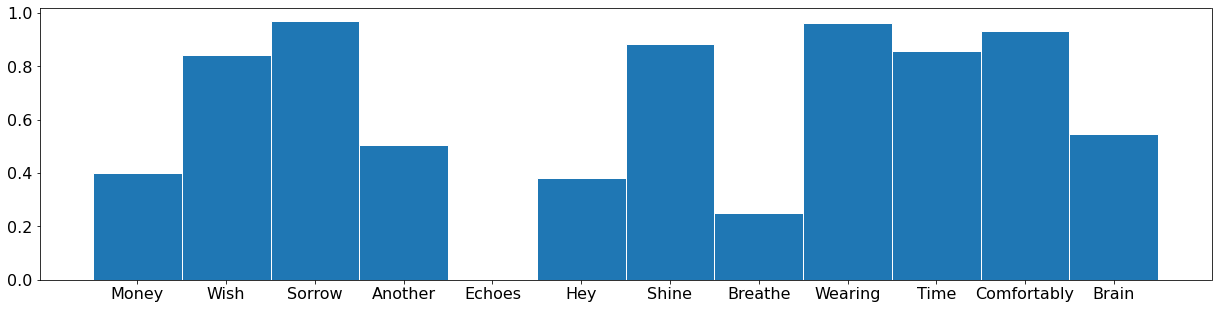

In [101]:
f1s = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)

fig = plt.figure(figsize=(21, 5))
plt.bar(np.arange(12), f1s, width=1, edgecolor="white", tick_label=list(label_mapping))

plt.show()

# Save the model

In [102]:
model.save(model_name)
#model.load(model_name)